# Data cleaning and preparation

In [1]:
!pip3 install pyspark

  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317161 sha256=d7aab1b7cb7ea991fe56641e522bf9975ed9137fb72104085173ff573b2bf2f8
  Stored in directory: c:\users\ahmed\appdata\local\pip\cache\wheels\9f\34\a4\159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import warnings
from wordcloud import WordCloud
import timeit
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("NYPD_Complaint_Data").getOrCreate()

# Read in the CSV file and parse the 'CMPLNT_FR_DT' column as a datetime format
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("NYPD_Complaint_Data_Historic.csv")
df = df.withColumn("CMPLNT_FR_DT", col("CMPLNT_FR_DT").cast("timestamp"))

# Check for any null or missing values in the 'CMPLNT_FR_DT' column
null_dates = df.filter(col("CMPLNT_FR_DT").isNull())
null_dates.show()

# Remove rows with null or missing values in the 'CMPLNT_FR_DT' column
df = df.na.drop(subset=["CMPLNT_FR_DT"])


+----------+------------+-------------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+----------------+-----------+-------------+-----------------+--------------------+-------------------+-----------------+--------+----------------+-----------+----------+----------+--------------+--------------+--------+----------------+------------+-------------+--------------------+--------------------+------------+-------------+--------------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|       CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|ADDR_PCT_CD|    RPT_DT|KY_CD|           OFNS_DESC|PD_CD|             PD_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|      BORO_NM|LOC_OF_OCCUR_DESC|       PREM_TYP_DESC|         JURIS_DESC|JURISDICTION_CODE|PARKS_NM|      HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|     SUSP_RACE|SUSP_SEX|TRANSIT_DISTRICT|    Latitude|    Longitude|             Lat_Lon|         PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|      VIC_RACE|V

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import StringType

# Create a Spark session
spark = SparkSession.builder.appName("NYPD_Complaint_Data").getOrCreate()

# Read in the CSV file and parse the 'CMPLNT_FR_DT' column as a datetime format
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("NYPD_Complaint_Data_Historic.csv")
df = df.withColumn("CMPLNT_FR_DT", col("CMPLNT_FR_DT").cast("timestamp"))

# Remove rows with null or missing values in the 'CMPLNT_FR_DT' column
df = df.na.drop(subset=["CMPLNT_FR_DT"])

# Remove any rows that will give the OutOfBoundsDatetime error
df = df.filter((col("CMPLNT_FR_DT") >= "1900-01-01") & (col("CMPLNT_FR_DT") <= "2023-04-12"))

# Convert date and time columns to datetime format
df = df.withColumn("CMPLNT_FR_TM", col("CMPLNT_FR_TM").cast("timestamp"))

# Fill in missing values with unknown category
df = df.withColumn("BORO_NM", when(col("BORO_NM").isNull(), "UNKNOWN").otherwise(col("BORO_NM")))
df = df.withColumn("OFNS_DESC", when(col("OFNS_DESC").isNull(), "UNKNOWN").otherwise(col("OFNS_DESC")))
df = df.withColumn("LAW_CAT_CD", when(col("LAW_CAT_CD").isNull(), "UNKNOWN").otherwise(col("LAW_CAT_CD")))

# Drop any rows with missing or invalid datetime values
df = df.na.drop(subset=["CMPLNT_FR_DT", "CMPLNT_FR_TM"])


# Data exploration and visualization

* Count the number of crimes by borough and visualize the distribution:

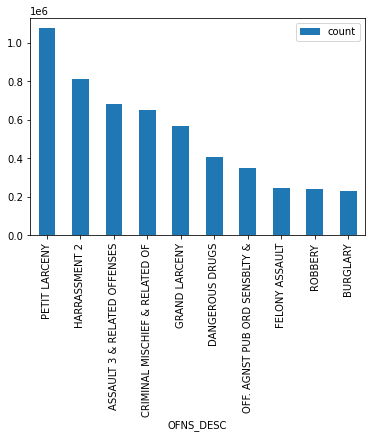

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

# Create a Spark session
spark = SparkSession.builder.appName("NYPD_Complaint_Data").getOrCreate()

# Read in the CSV file and parse the 'CMPLNT_FR_DT' column as a datetime format
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("NYPD_Complaint_Data_Historic.csv")

# Generate descriptive statistics
stats = df.describe()

# Create a bar chart of the top 10 offenses by frequency
top_10_offenses = df.groupBy("OFNS_DESC").count().orderBy(desc("count")).limit(10).toPandas()
top_10_offenses.plot(kind="bar", x="OFNS_DESC", y="count")
plt.xticks(rotation=90)
plt.show()


* Count the number of crimes by offense type and visualize the distribution

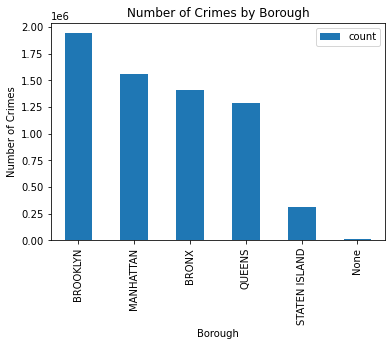

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

# Create a Spark session
spark = SparkSession.builder.appName("NYPD_Complaint_Data").getOrCreate()

# Read in the CSV file and parse the 'CMPLNT_FR_DT' column as a datetime format
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("NYPD_Complaint_Data_Historic.csv")

# Count the number of crimes by borough
crimes_by_borough = df.groupBy("BORO_NM").count().orderBy(desc("count")).toPandas()

# Visualize the distribution
crimes_by_borough.plot(kind="bar", x="BORO_NM", y="count")
plt.title("Number of Crimes by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Crimes")
plt.show()


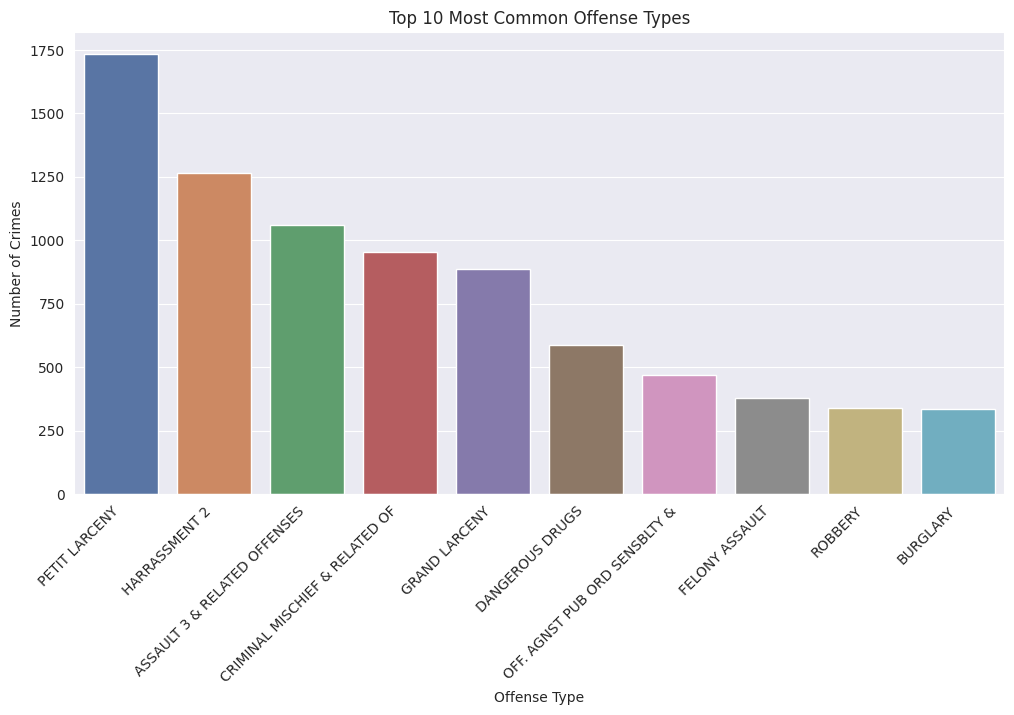

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

# Create a Spark session
spark = SparkSession.builder.appName("NYPD_Complaint_Data").getOrCreate()

# Read in the CSV file and parse the 'CMPLNT_FR_DT' column as a datetime format
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("NYPD_Complaint_Data_Historic.csv")

# Count the number of crimes by offense type
offense_counts = df.groupBy("OFNS_DESC").count().orderBy(desc("count")).limit(10).toPandas()

# Create a bar plot
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.title('Top 10 Most Common Offense Types')
plt.xticks(rotation=45, ha='right')
sns.barplot(x="OFNS_DESC", y="count", data=offense_counts, palette='deep')
plt.xlabel('Offense Type')
plt.ylabel('Number of Crimes')
plt.show()


### Victim and Suspect Analysis:
* Investigate victim demographics such as age, gender, and race to understand the profile of crime victims.
* Analyze the relationship between victim characteristics and crime types or locations.
* Explore perpetrator information (if available) to identify patterns and relationships with crime incidents.

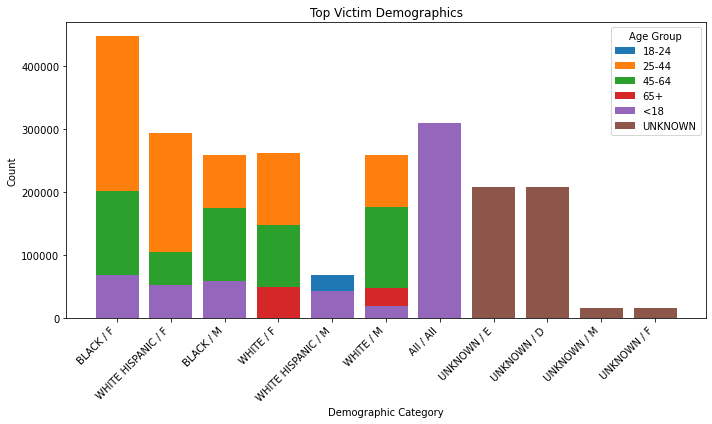

In [9]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Specify the victim column names
victim_cols = ['VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX']

# Check if the victim columns exist in the dataset
missing_cols = [col for col in victim_cols if col not in df_spark.columns]
if missing_cols:
    raise ValueError(f"The following columns are missing in the dataset: {missing_cols}")

# Count the occurrences of victim demographics
victim_counts = df_spark.groupBy(victim_cols).count()

# Set a threshold count for filtering categories
threshold = 5000

# Filter the victim counts based on the threshold
filtered_counts = victim_counts.filter(f'count >= {threshold}')

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
filtered_counts_pd = filtered_counts.toPandas()

# Select top N categories
top_n = 5
top_categories = filtered_counts_pd.groupby('VIC_AGE_GROUP').apply(lambda x: x.nlargest(top_n, 'count')).reset_index(drop=True)

# Add a row for victims under 18
under_18_counts = df_spark.filter(df_spark['VIC_AGE_GROUP'] == '<18').groupBy(victim_cols).count().toPandas()
under_18_row = pd.DataFrame({'VIC_AGE_GROUP': '<18', 'VIC_RACE': 'All', 'VIC_SEX': 'All', 'count': under_18_counts['count'].sum()}, index=[0])
top_categories = pd.concat([top_categories, under_18_row])

# Plotting victim demographics
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors[:len(top_categories['VIC_AGE_GROUP'].unique())]

for i, age_group in enumerate(top_categories['VIC_AGE_GROUP'].unique()):
    group_df = top_categories[top_categories['VIC_AGE_GROUP'] == age_group]
    labels = group_df['VIC_RACE'] + " / " + group_df['VIC_SEX']
    plt.bar(labels, group_df['count'], color=colors[i], label=age_group)

plt.title('Top Victim Demographics')
plt.xlabel('Demographic Category')
plt.ylabel('Count')
plt.legend(title='Age Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


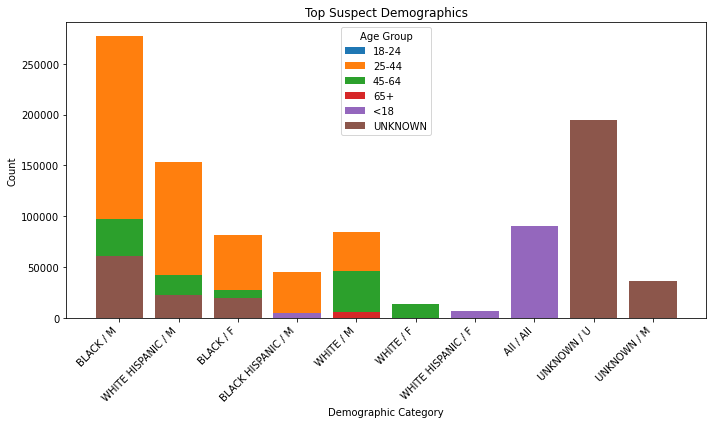

In [10]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Specify the suspect column names
suspect_cols = ['SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX']

# Check if the suspect columns exist in the dataset
missing_cols = [col for col in suspect_cols if col not in df_spark.columns]
if missing_cols:
    raise ValueError(f"The following columns are missing in the dataset: {missing_cols}")

# Count the occurrences of suspect demographics
suspect_counts = df_spark.groupBy(suspect_cols).count()

# Set a threshold count for filtering categories
threshold = 5000

# Filter the suspect counts based on the threshold
filtered_counts = suspect_counts.filter(f'count >= {threshold}')

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
filtered_counts_pd = filtered_counts.toPandas()

# Select top N categories
top_n = 5
top_categories = filtered_counts_pd.groupby('SUSP_AGE_GROUP').apply(lambda x: x.nlargest(top_n, 'count')).reset_index(drop=True)

# Add a row for suspects under 18
under_18_counts = df_spark.filter(df_spark['SUSP_AGE_GROUP'] == '<18').groupBy(suspect_cols).count().toPandas()
under_18_row = pd.DataFrame({'SUSP_AGE_GROUP': '<18', 'SUSP_RACE': 'All', 'SUSP_SEX': 'All', 'count': under_18_counts['count'].sum()}, index=[0])
top_categories = pd.concat([top_categories, under_18_row])

# Plotting suspect demographics
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors[:len(top_categories['SUSP_AGE_GROUP'].unique())]

for i, age_group in enumerate(top_categories['SUSP_AGE_GROUP'].unique()):
    group_df = top_categories[top_categories['SUSP_AGE_GROUP'] == age_group]
    labels = group_df['SUSP_RACE'] + " / " + group_df['SUSP_SEX']
    plt.bar(labels, group_df['count'], color=colors[i], label=age_group)

plt.title('Top Suspect Demographics')
plt.xlabel('Demographic Category')
plt.ylabel('Count')
plt.legend(title='Age Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Crime Clearances and Arrests:
* Analyze the rates of crime clearance and arrests to understand the efficiency of law enforcement.
* Investigate the factors associated with successful crime clearances.
* Identify the crime types or neighborhoods with higher clearance rates.

<Figure size 720x432 with 0 Axes>

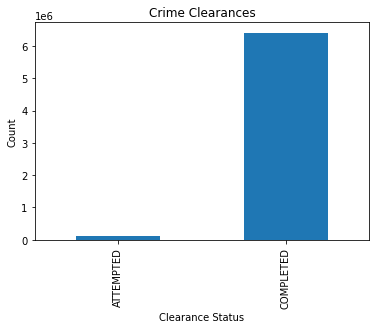

<Figure size 432x288 with 0 Axes>

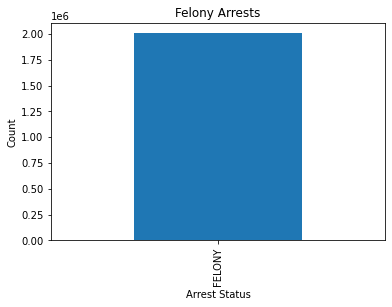

In [11]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Select relevant columns for crime clearances and arrests
clearance_cols = ['CRM_ATPT_CPTD_CD', 'LAW_CAT_CD']

# Filter rows with valid clearance information
df_clearances = df_spark.filter(df_spark['CRM_ATPT_CPTD_CD'].isNotNull())

# Count the occurrences of crime clearances
clearance_counts = df_clearances.groupBy('CRM_ATPT_CPTD_CD').count()

# Count the occurrences of arrests by offense level
arrest_counts = df_clearances.filter(df_clearances['LAW_CAT_CD'] == 'FELONY').groupBy('LAW_CAT_CD').count()

# Convert the Spark DataFrames to Pandas DataFrames for visualization
clearance_counts_pd = clearance_counts.toPandas()
arrest_counts_pd = arrest_counts.toPandas()

# Plotting crime clearances
plt.figure(figsize=(10, 6))
clearance_counts_pd.plot(x='CRM_ATPT_CPTD_CD', y='count', kind='bar', legend=False)
plt.title('Crime Clearances')
plt.xlabel('Clearance Status')
plt.ylabel('Count')
plt.show()

# Plotting felony arrests
plt.figure(figsize=(6, 4))
arrest_counts_pd.plot(x='LAW_CAT_CD', y='count', kind='bar', legend=False)
plt.title('Felony Arrests')
plt.xlabel('Arrest Status')
plt.ylabel('Count')
plt.show()


### Crime Density Mapping:
* Create density maps to visualize the intensity of crime incidents in different areas. This can help identify areas with high crime density and assist in resource allocation for law enforcement agencies.

In [13]:
from pyspark.sql import SparkSession
import folium

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Drop rows with NaN values in 'Latitude' and 'Longitude' columns
df_spark = df_spark.dropna(subset=['Latitude', 'Longitude'])

# Select a subset of rows
subset_df = df_spark.select('Latitude', 'Longitude').limit(1000).toPandas()

# Create a map centered around New York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Plot each point on the map
for index, row in subset_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(ny_map)

# Display the map
ny_map


In [15]:
from pyspark.sql import SparkSession
import folium
from folium.plugins import HeatMap

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Drop rows with NaN values in 'Latitude' and 'Longitude' columns
df_spark = df_spark.dropna(subset=['Latitude', 'Longitude'])

# Select a subset of rows
subset_df = df_spark.select('Latitude', 'Longitude').limit(1000).toPandas()

# Create a map centered around New York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Create a list of crime locations
crime_locations = subset_df[['Latitude', 'Longitude']].values.tolist()

# Add the heat map layer to the map
HeatMap(crime_locations).add_to(ny_map)

# Display Map
ny_map


### Crime Time Analysis:
* Analyze temporal patterns: Explore the distribution of crimes across different times of the day, days of the week, or months of the year.
* Visualize trends: Use histograms, line plots, or heatmaps to visualize the patterns and fluctuations in crime occurrence.
* Inform law enforcement strategies: Gain insights into peak crime hours or days, identify high crime density areas, and allocate resources effectively for crime prevention and response.

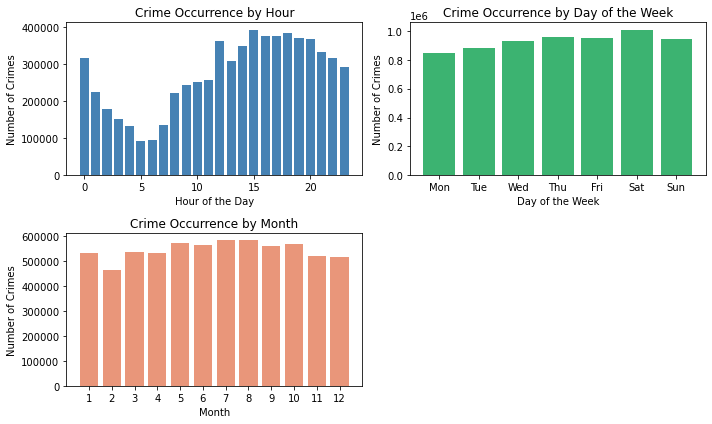

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, to_timestamp, hour, dayofweek, month
import matplotlib.pyplot as plt

# Set up a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.format('csv').option('header', True).load('NYPD_Complaint_Data_Historic.csv')

# Convert the date and time columns to datetime format
df_spark = df_spark.withColumn('CMPLNT_FR_DT', to_date('CMPLNT_FR_DT', 'MM/dd/yyyy'))
df_spark = df_spark.withColumn('CMPLNT_FR_TM', to_timestamp('CMPLNT_FR_TM', 'HH:mm:ss'))

# Filter out rows with missing or invalid date/time values
df_spark = df_spark.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM'])

# Extract time-related features
df_spark = df_spark.withColumn('Hour', hour('CMPLNT_FR_TM'))
df_spark = df_spark.withColumn('DayOfWeek', dayofweek('CMPLNT_FR_DT'))
df_spark = df_spark.withColumn('Month', month('CMPLNT_FR_DT'))

# Count the occurrences of crimes by hour
crime_by_hour = df_spark.groupBy('Hour').count().orderBy('Hour')

# Count the occurrences of crimes by day of the week
crime_by_dayofweek = df_spark.groupBy('DayOfWeek').count().orderBy('DayOfWeek')

# Count the occurrences of crimes by month
crime_by_month = df_spark.groupBy('Month').count().orderBy('Month')

# Convert Spark DataFrames to Pandas DataFrames
crime_by_hour = crime_by_hour.toPandas()
crime_by_dayofweek = crime_by_dayofweek.toPandas()
crime_by_month = crime_by_month.toPandas()

# Plotting the crime trend analysis
plt.figure(figsize=(10, 6))

# Plot crime by hour
plt.subplot(2, 2, 1)
plt.bar(crime_by_hour['Hour'], crime_by_hour['count'], color='steelblue')
plt.title('Crime Occurrence by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')

# Plot crime by day of the week
plt.subplot(2, 2, 2)
plt.bar(crime_by_dayofweek['DayOfWeek'], crime_by_dayofweek['count'], color='mediumseagreen')
plt.title('Crime Occurrence by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot crime by month
plt.subplot(2, 2, 3)
plt.bar(crime_by_month['Month'], crime_by_month['count'], color='darksalmon')
plt.title('Crime Occurrence by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()


# Data analysis and modeling:

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Sample 10% of the rows
df = df.sample(fraction=0.1, seed=42)

# Fill missing values with 'Unknown'
df = df.fillna('Unknown')

# Select features and target variable
X = ["BORO_NM", "KY_CD"]
y = "OFNS_DESC"

# One-hot encode the categorical features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in X]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{}_encoded".format(column) for column in X])
assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
label_indexer = StringIndexer(inputCol=y, outputCol="label")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)

pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [label_indexer] + [rf])
model = pipeline.fit(df)

# Make predictions on the test set
predictions = model.transform(df)

# Evaluate accuracy of the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9268751465946353


# Data aggregation and reporting:

In [47]:
from pyspark.sql.functions import count

# Summarize the data by borough and offense type
summary = df.groupBy(["BORO_NM", "OFNS_DESC"]).agg(count("*").alias("Count"))

# Write the summary to a CSV file
summary.write.csv("crime_summary.csv", header=True)


In [64]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Fill missing values with 'Unknown'
df = df.na.fill('Unknown')

# Select features and target variable
data = df.select("BORO_NM", "KY_CD", "OFNS_DESC")

# Encode categorical features using StringIndexer
string_indexer = StringIndexer(inputCol="BORO_NM", outputCol="BORO_NM_Indexed")
string_indexer_model = string_indexer.fit(data)
data = string_indexer_model.transform(data)

# Encode target variable using StringIndexer
label_indexer = StringIndexer(inputCol="OFNS_DESC", outputCol="label")
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)

# Combine multiple columns into a single column of feature vectors
vector_assembler = VectorAssembler(inputCols=["BORO_NM_Indexed", "KY_CD"], outputCol="features")
data = vector_assembler.transform(data)

# Split data into training and testing sets
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Train a random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train)

# Get input from user
boro = input("Enter borough name: ")
ky_cd = int(input("Enter offense code: "))

# Encode input using StringIndexerModel
boro_encoded = string_indexer_model.transform(spark.createDataFrame([(boro,)], ["BORO_NM"])).collect()[0]["BORO_NM_Indexed"]

# Combine input into a single feature vector
input_features = vector_assembler.transform(spark.createDataFrame([(boro_encoded, ky_cd)], ["BORO_NM_Indexed", "KY_CD"])).collect()[0]["features"]

# Make prediction on input
y_pred_index = model.transform(spark.createDataFrame([(input_features,)], ["features"])).collect()[0]["prediction"]

# Decode prediction using label indexer
y_pred = label_indexer_model.labels[int(y_pred_index)]

# Print prediction
print("Predicted offense description:", y_pred)


Enter borough name: BROOKLYN
Enter offense code: 578
Predicted offense description: HARRASSMENT 2
